# VibeCheck-AI

[Dataset]("https://www.kaggle.com/datasets/kushagra3204/sentiment-and-emotion-analysis-dataset")

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Exploratory Analysis

In [12]:
df_combined_emotion = pd.read_csv('raw_data/combined_emotion.csv')
df_combined_sentiment = pd.read_csv('raw_data/combined_sentiment_data.csv')

print(df_combined_emotion.shape, df_combined_sentiment.shape)

(422746, 2) (3309, 2)


In [13]:
print("Combined Emotion Dataframe")
df_combined_emotion.head(10)

Combined Emotion Dataframe


,sentence,emotion
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sad
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sad
4,i am a kindergarten teacher and i am thoroughl...,fear
5,i was beginning to feel quite disheartened,sad
6,i would think that whomever would be lucky eno...,love
7,i fear that they won t ever feel that deliciou...,joy
8,im forever taking some time out to have a lie ...,suprise
9,i can still lose the weight without feeling de...,sad


In [14]:
print("Combined Sentiment Dataframe")
df_combined_sentiment.head(10)

Combined Sentiment Dataframe


,sentence,sentiment
0,So there is no way for me to plug it in here i...,negative
1,"Good case, Excellent value.",positive
2,Great for the jawbone.,positive
3,Tied to charger for conversations lasting more...,negative
4,The mic is great.,positive
5,I have to jiggle the plug to get it to line up...,negative
6,If you have several dozen or several hundred c...,negative
7,If you are Razr owner...you must have this!,positive
8,"Needless to say, I wasted my money.",negative
9,What a waste of money and time!.,negative


In [15]:
# We dont want the combined sentiment dataset
del(df_combined_sentiment)
del(df_combined_emotion)

In [26]:
df = pd.read_csv("raw_data/combined_emotion.csv")
df.duplicated().sum()

np.int64(6623)

In [27]:
print(f"Shape before droping duplcates: {df.shape}")
df.drop_duplicates(inplace=True)
df.duplicated().sum()
print("-"*100)
print(f"Shape after droping duplcates: {df.shape}")

Shape before droping duplcates: (422746, 2)
----------------------------------------------------------------------------------------------------
Shape after droping duplcates: (416123, 2)


In [28]:
# Emotions distribution in absolute values
df['emotion'].value_counts()

emotion
joy        140779
sad        120989
anger       57235
fear        47664
love        34497
suprise     14959
Name: count, dtype: int64

In [31]:
# Emotions distribution in percentage
df['emotion'].value_counts(normalize=True).round(3)

emotion
joy        0.338
sad        0.291
anger      0.138
fear       0.115
love       0.083
suprise    0.036
Name: proportion, dtype: float64

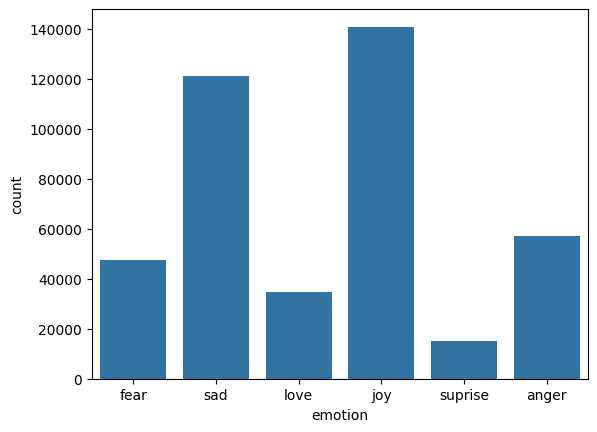

In [35]:
sns.countplot(x = df['emotion']);

In [38]:
# Balancing classes
sad = df[df['emotion'] == 'sad'].sample(14959)
love = df[df['emotion'] == 'love'].sample(14959)
joy = df[df['emotion'] == 'joy'].sample(14959)
fear = df[df['emotion'] == 'fear'].sample(14959)
anger = df[df['emotion'] == 'anger'].sample(14959)
surprise = df[df['emotion'] == 'surprise']

In [42]:
df_balanced = pd.concat((sad, love, joy, fear, anger,surprise))

In [46]:
print(f"Unbalanced dataframe shape: {df.shape}")
print(f"Balanced dataframe shape: {df_balanced.shape}")
print(f"Columns lost: {df.shape[0]-df_balanced.shape[0]}")

Unbalanced dataframe shape: (416123, 2)
Balanced dataframe shape: (74795, 2)
Columns lost: 341328


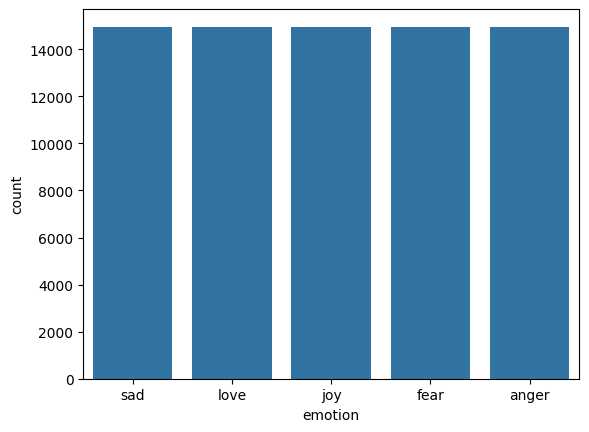

In [47]:
sns.countplot(x = df_balanced['emotion']);